# Data Analysis Interview Challenge


## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
%matplotlib inline

In [3]:
with open('Data/logins.json') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [4]:
df.head(20)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


In [5]:
# Range of df
df.login_time.min(), df.login_time.max()

('1970-01-01 20:12:16', '1970-04-13 18:57:38')

### Imported data spans a three month range from January 1st to April 13th of 1970. The login data are not ordered. (Are they aggregated to the file from multiple sources?)

In [6]:
# standardize datetime
df['login_time'] = pd.to_datetime(df['login_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## Identify and remove incomplete datetimes

In [7]:
df.count()

login_time    93142
dtype: int64

In [8]:
# identify and remove incomplete datetimes
df[(df.login_time.dt.hour == 0) & (df.login_time.dt.minute == 0) & (df.login_time.dt.second == 0)]

,login_time
32456,1970-02-15
37739,1970-02-21


In [9]:
df = df[~((df.login_time.dt.hour == 0) & (df.login_time.dt.minute == 0) & (df.login_time.dt.second == 0))]
df.count()

login_time    93140
dtype: int64

In [10]:
df[(df.login_time.dt.year == 0) | (df.login_time.dt.month == 0) | (df.login_time.dt.day == 0)]

,login_time


### Removed two entries missing times and zero entries with incomplete dates.

In [11]:
# Sort values by login
sorted = df.sort_values(by='login_time')

sorted.head(15)


,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
5,1970-01-01 20:21:41
10,1970-01-01 20:26:05
4,1970-01-01 20:26:21
11,1970-01-01 20:31:03
12,1970-01-01 20:34:46


### Aggregate sorted logins by 15-minute intervals

In [12]:
# Aggregate these login counts based on 15 minute time intervals
df_15min = sorted.resample('15T', on='login_time').count()
df_15min.columns=['count']
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## Data Exploration and Visualizations

In [13]:
# visualize and describe the resulting time series of login counts


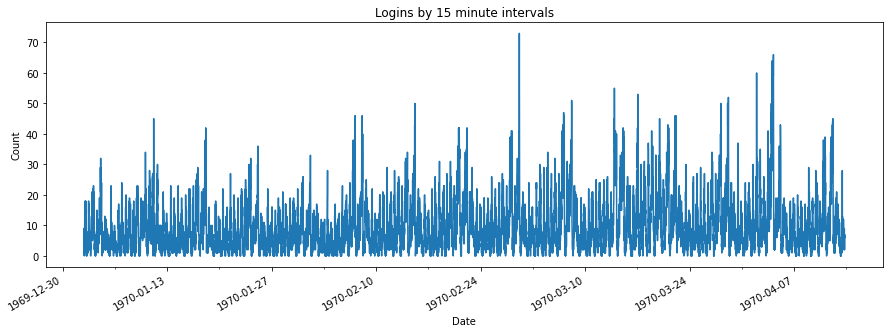

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(15, 5))
plt.title('Logins by 15 minute intervals')
plt.ylabel('Count')
plt.xlabel('Date')
ax.plot(df_15min['count'])
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.show()


#### The data appears to have a repeating pattern over a seven day cycle with a large spike over a few days each week. The counts also seem to trend higher as the months pass. I'll examine the data in smaller intervals to better observe the details of the the pattern beginning with observing each month separately.

### Data by month (weekends highlighted)

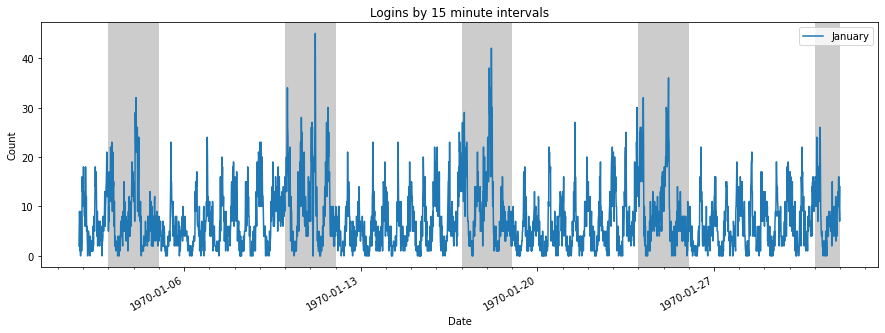

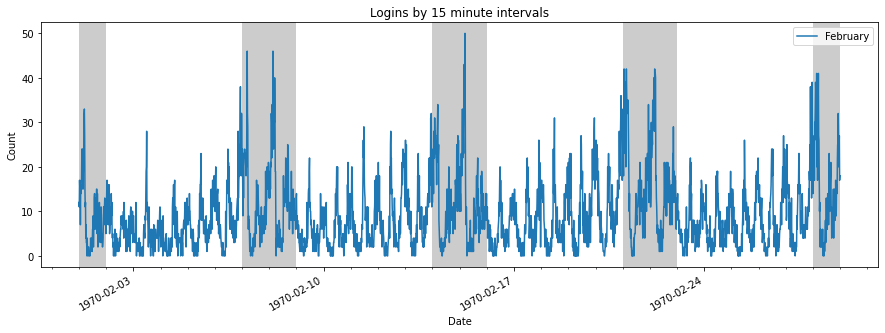

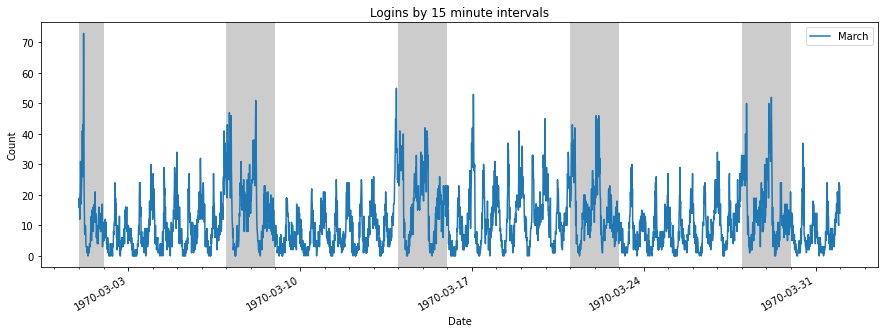

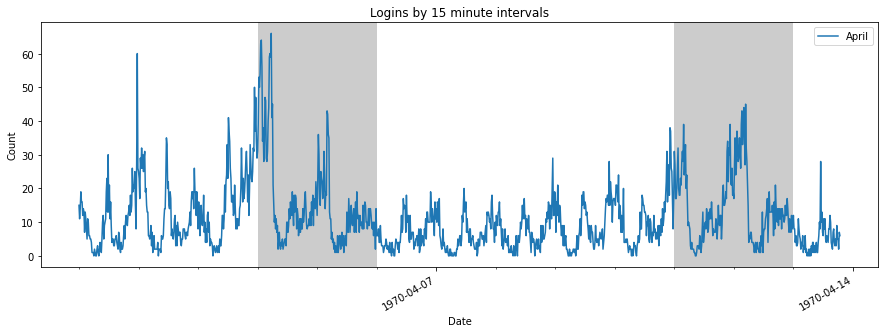

In [15]:
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

def highlight_datetimes(df, indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='gray', edgecolor='none', alpha=.4)
        i += 1
        
groups = df_15min.groupby(pd.Grouper(freq='M'))
months = pd.DataFrame()
for name, group in groups:
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(group, label=name.month_name())
    weekend_indices = find_weekend_indices(group.index)
    highlight_datetimes(group, weekend_indices, ax)
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) #monday
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
    plt.title('Logins by 15 minute intervals')
    plt.legend(loc='upper right')
    plt.ylabel('Count')
    plt.xlabel('Date')
plt.show()

#### There is a clear pattern of peak logins on the weekend. The weekdays have a less apparent pattern of a slow rise in logins from the beginning of the week through Wednesdays.


### Data by week (weekend highlighted)

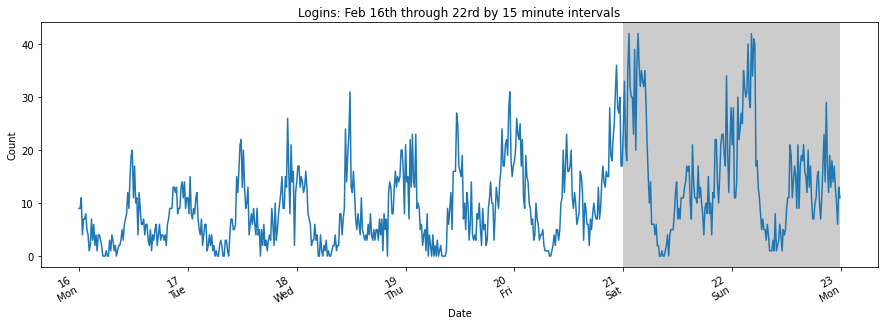

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_15min['count'].loc['1970-02-16':'1970-02-22'])
weekend_indices = find_weekend_indices(df_15min['count'].loc['1970-02-16':'1970-02-22'].index)
highlight_datetimes(df_15min['count'].loc['1970-02-16':'1970-02-22'], weekend_indices, ax)
plt.title('Logins: Feb 16th through 22rd by 15 minute intervals')
plt.ylabel('Count')
plt.xlabel('Date')
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU)))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%a'))
plt.show()

#### Most weekdays seem to have a peak mid-day and mid-night with valleys on either side. Weekend days have a slightly different pattern, with a large peak at or just after midnight, then dropping sharply before a small afternoon spike.¶

In [17]:
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Average totals by day

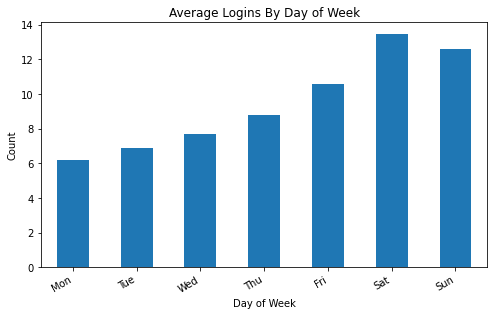

In [18]:
import calendar
fig, ax = plt.subplots(figsize=(8, 5))
df_15min['weekday'] = df_15min.index.weekday
dgroups = df_15min[['count', 'weekday']].groupby('weekday').mean().plot(kind='bar', ax=ax, legend=None)
plt.title('Average Logins By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
fig.autofmt_xdate()
ax.set_xticklabels(list(calendar.day_abbr))

plt.show()

#### The average total logins by day of the week again shows a slow and steady rise starting on Monday and increasing steadily approaching the weekend with Saturday having a slightly higher average number of logins that Sunday.


## weekday vs weekend


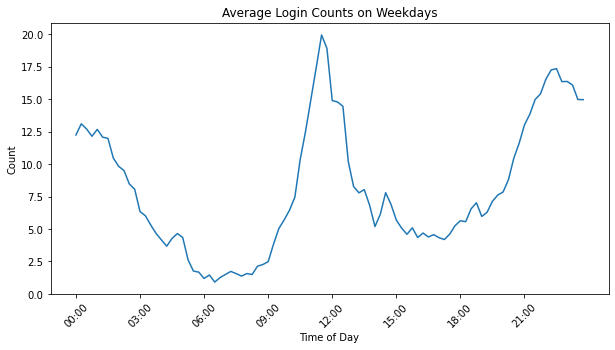

In [19]:
df_15min['time'] = df_15min.index.time

fig, ax = plt.subplots(figsize=(10, 5))
weekday_ave = df_15min[df_15min['weekday'].isin([0, 1, 2, 3, 4])][['count', 'time']].groupby('time').mean()
ax.plot(weekday_ave)
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.title('Average Login Counts on Weekdays')
dates_rng = pd.date_range("00:00", "23:59", freq="3H").time
plt.xticks(dates_rng, [dtz.strftime('%H:%M') for dtz in dates_rng], rotation=45)
plt.show()

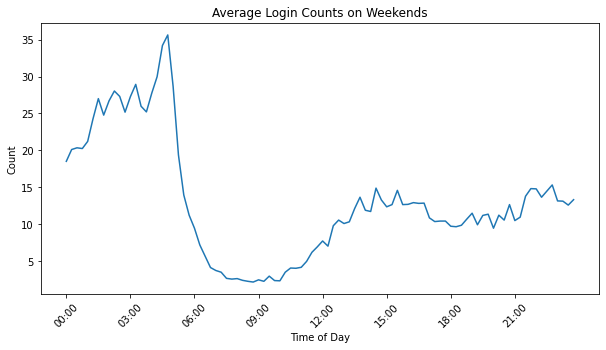

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
weekend_ave = df_15min[df_15min['weekday'].isin([5, 6])][['count', 'time']].groupby('time').mean()
ax.plot(weekend_ave)
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.title('Average Login Counts on Weekends')
dates_rng = pd.date_range("00:00", "23:59", freq="3H").time
plt.xticks(dates_rng, [dtz.strftime('%H:%M') for dtz in dates_rng], rotation=45)
plt.show()

#### Weekdays and weekends have individually distinct patterns. Weekdays have two distinct peaks - one around midday and the other around midnight. Early to mid morning shows the lowest average number of logins. Weekends have the most activity between midnight and 5am. Then there is a sharp drop at 6am with a very slow rise to a small afternoon peak at 3pm.


## AUTOCORRELATION PLOTS AND MOVING THINGS?



# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment

    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the cityoperations team along with any caveats.


1. The key measure of success of this experiment would be to see an increase in the number of toll crossings from prior to the toll reimbursing.

2. a. Randomly split drivers into two groups - control and test. The control drivers would work as normal, but the test drivers would be reimbursed for their toll fees. Rides would be monitored for a set amount of time - perhaps 2 monthes - and toll crossing between the two groups would be compared to see if a statistically significant difference occurred between the two.

    b. Apply a two sided t-test with a 95% confidence interval to see if there is a statistially sifnificant increase in the number of toll crossings. 
        Null hypothesis: There is no change in the number of rides with a toll charge.
        Alternate hypothesis: There is a change in the number of rides with a toll charge.
        
    c. Presuming that the null hypothesis was indeed rejected, I would recommend that the city operations team expand the toll reimbursement program to more of their fleet.


# Part 3 ‑ Predictive modeling¶

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [21]:
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [22]:
import sklearn
print(sklearn.__version__)

0.23.1


In [23]:
with open('Data/ultimate_data_challenge.json') as ult_file:
    ult_data = json.load(ult_file)
ult_df = pd.DataFrame(ult_data)   
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Three features - ave_rating_by_driver, avg_rating_of_driver, and phone contain null values.

In [24]:
# standardize datetime
ult_df.last_trip_date = pd.to_datetime(ult_df.last_trip_date)
ult_df.signup_date = pd.to_datetime(ult_df.signup_date)

ult_df.head(10)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [25]:
ult_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Possible outliers: The max avg_dist of 160.96 miles in first 30 days seems large comparatively, but could be due to a user taking one long trip. The max of 125 trips_in_first_30_days also seems to be an outlier. It's feasible that a user using the service to go from appointment to appointment around town could rack up a high number of trips or it could be bad data. Regardless, these large numbers can skew the data.



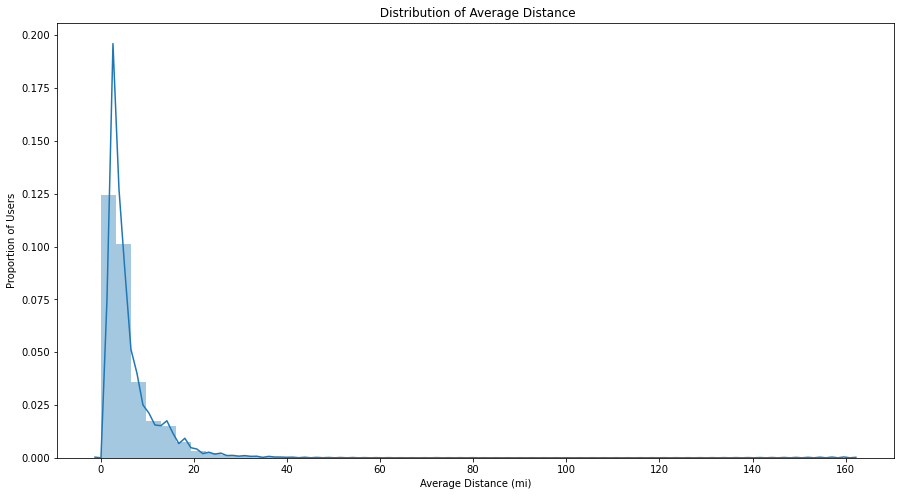

In [26]:
plt.figure(figsize=(15,8))
sns.distplot(ult_df['avg_dist'])
plt.title(' Distribution of Average Distance')
plt.xlabel('Average Distance (mi)')
plt.ylabel('Proportion of Users')

plt.show()

In [27]:
ult_df[ult_df.avg_dist == 0.0]['avg_dist'].count()


150

There are a lot of trips at or near zero. These could be caused by cancellations being recorded or some other error, but should be removed from the data to be examined.

In [28]:
ult_df[ult_df.avg_dist == 0.0]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
72,Astapor,1,2014-01-07,5.0,1.0,2014-01-08,iPhone,0.0,False,100.0,0.0,3.0
116,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.0,5.0
188,Winterfell,1,2014-01-11,NaN,1.0,2014-01-14,Android,0.0,False,100.0,0.0,5.0
356,Winterfell,1,2014-01-15,4.0,1.0,2014-01-16,Android,0.0,False,100.0,0.0,5.0
479,Winterfell,1,2014-01-24,5.0,1.0,2014-01-25,iPhone,0.0,False,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
47929,Winterfell,0,2014-01-07,4.0,1.0,2014-03-14,iPhone,0.0,False,100.0,0.0,5.0
48283,Winterfell,0,2014-01-18,NaN,1.0,2014-03-08,Android,0.0,False,0.0,0.0,5.0
49464,Astapor,0,2014-01-03,5.0,1.0,2014-04-28,iPhone,0.0,False,100.0,0.0,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.0,5.0


In [29]:
# Examine unusually high average distances
ult_df[ult_df.avg_dist > 100].sort_values('avg_dist', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0


#### avg_dist: the average distance in miles per trip taken in the first 30 days after signup

These two entries raise a red flag. They are stating the zero trips were taken in the first 30 days, yet are recording a non-zero average distance in that 30 day timeframe.

In [30]:
ult_df[ult_df.avg_dist > 100].sort_values('avg_dist', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0


In [31]:
ult_df[(ult_df.avg_dist > 0) & (ult_df.trips_in_first_30_days == 0)]['avg_dist'].count()

15334

#### Out of 50000 entries, 15334 appear to have this error. That's 31% of the data. Very problematic for such a large portion of the data to contain an error. 

In [32]:
ult_df[ult_df.trips_in_first_30_days > 45][['avg_dist', 'trips_in_first_30_days']].sort_values('trips_in_first_30_days', 
                                                                                        ascending=False).head()


,avg_dist,trips_in_first_30_days
18514,2.02,125
99,2.86,73
3030,2.32,71
29070,1.45,63
48804,2.30,58


In [33]:
ult_df[ult_df.avg_surge > 2][['avg_surge', 'surge_pct']].sort_values('avg_surge', ascending=False).head()

,avg_surge,surge_pct
13861,8.00,100.0
30477,5.75,100.0
2817,5.00,100.0
21894,5.00,100.0
19191,5.00,100.0


#### Examining the outlier of 125 trips in the first 30 days and the next largest value of 73, while possible it is a true record, it is still large enough that it would skew data for that column. Similarly of the avg_surge value of 8.

### Clean Data

In [34]:
# track loss
ult_df.shape

(50000, 12)

In [35]:
# remove outliers   
clean_df = ult_df[ult_df.trips_in_first_30_days < 125]
clean_df = clean_df[(clean_df.avg_surge < 8)]
clean_df.shape  #n-2

(49998, 12)

In [36]:
# remove entries recording a non-zero average distance when zero trips were taken in the first 30 days

clean_df.drop(clean_df.loc[(clean_df.avg_dist > 0) & (clean_df.trips_in_first_30_days == 0)].index, inplace=True)
clean_df.shape #n-15334

(34664, 12)

In [37]:
# clean_df[clean_df.avg_dist == 0.0]['avg_dist'].count()   =150
clean_df.drop(clean_df.loc[clean_df.avg_dist == 0.0].index, inplace=True)
clean_df.shape #n-150

(34514, 12)

#### 1. We've retained 69% of the original data.

In [38]:
34514/50000

0.69028

#### Convert categoricals to numeric

In [39]:
phone_int = {"Android": 1, "iPhone": 2, None: None}
city_int = {"Astapor": 1, "King\'s Landing": 2, "Winterfell":3}

In [40]:
# add numeric code from dict to 'phone_int' and verify one to one with 'phone'
clean_df['phone_int'] = clean_df.apply(lambda row: phone_int[row['phone']], axis=1)
print('phone_int: \n{}\nphone: \n{}'.format(clean_df['phone_int'].value_counts(), clean_df['phone'].value_counts()))

phone_int: 
2.0    23828
1.0    10369
Name: phone_int, dtype: int64
phone: 
iPhone     23828
Android    10369
Name: phone, dtype: int64


In [41]:
# add numeric code from dict to 'city_int' and verify one to one with 'city'
clean_df['city_int'] = clean_df.apply(lambda row: city_int[row['city']], axis=1)
print('city_int: \n{}\ncity: \n{}'.format(clean_df['city_int'].value_counts(), clean_df['city'].value_counts()))

city_int: 
3    16752
1    11175
2     6587
Name: city_int, dtype: int64
city: 
Winterfell        16752
Astapor           11175
King's Landing     6587
Name: city, dtype: int64


#### Convert to days from jan 1 for calculations and modeling

In [42]:
jan_1 = datetime.strptime('Jan 1 2014', '%b %d %Y')

# create columns of day counts for modeling: 'signup_days_since_jan_1', 'last_trip_days_since_jan_1'
clean_df['signup_days_since_jan_1'] = clean_df.apply(lambda row: (row['signup_date'] - jan_1).days, axis=1)
clean_df['last_trip_days_since_jan_1'] = clean_df.apply(lambda row: (row['last_trip_date'] - jan_1).days, axis=1)

clean_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,phone_int,city_int,signup_days_since_jan_1,last_trip_days_since_jan_1
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2.0,2,24,167
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2.0,1,5,6
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2.0,2,9,179
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.0,3,26,73
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,2.0,3,8,156


In [43]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34514 entries, 0 to 49998
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   city                        34514 non-null  object        
 1   trips_in_first_30_days      34514 non-null  int64         
 2   signup_date                 34514 non-null  datetime64[ns]
 3   avg_rating_of_driver        30191 non-null  float64       
 4   avg_surge                   34514 non-null  float64       
 5   last_trip_date              34514 non-null  datetime64[ns]
 6   phone                       34197 non-null  object        
 7   surge_pct                   34514 non-null  float64       
 8   ultimate_black_user         34514 non-null  bool          
 9   weekday_pct                 34514 non-null  float64       
 10  avg_dist                    34514 non-null  float64       
 11  avg_rating_by_driver        34407 non-null  float64   

In [44]:
# clean_df['last_trip_date'].max()

Assume this data was pulled on 7/1/14 and use that as the basis for creating the 'active' labels for modeling. This fits as we're looking for the fraction of users active after 6 months and our signup period begins 1/1/14.

In [45]:
# create column denoting whether or not client was active in last 30 days: 'active'

last_date = ult_df['last_trip_date'].max()
clean_df['active'] = clean_df.apply(lambda row: (last_date - row['last_trip_date']).days <= 30, axis=1)

clean_df[['last_trip_date', 'active']].head(10) #check

,last_trip_date,active
0,2014-06-17,True
2,2014-01-07,False
3,2014-06-29,True
4,2014-03-15,False
5,2014-06-06,True
6,2014-01-25,False
7,2014-01-29,False
8,2014-02-01,False
9,2014-01-05,False
10,2014-05-30,False


In [46]:
clean_df[clean_df['active']]['active'].count()/clean_df['active'].count()

0.38300399837747

#### Ultimate retained 38% of 34,514 customers after 6 months.

### Prep and impute missing data for modeling

In [47]:
# Keep only features for used for modeling
clean_imp = clean_df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'city_int', 
                      'last_trip_days_since_jan_1', 'phone_int', 'signup_days_since_jan_1', 'surge_pct', 
                      'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'active']]


In [48]:
clean_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34514 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   avg_dist                    34514 non-null  float64
 1   avg_rating_by_driver        34407 non-null  float64
 2   avg_rating_of_driver        30191 non-null  float64
 3   avg_surge                   34514 non-null  float64
 4   city_int                    34514 non-null  int64  
 5   last_trip_days_since_jan_1  34514 non-null  int64  
 6   phone_int                   34197 non-null  float64
 7   signup_days_since_jan_1     34514 non-null  int64  
 8   surge_pct                   34514 non-null  float64
 9   trips_in_first_30_days      34514 non-null  int64  
 10  ultimate_black_user         34514 non-null  bool   
 11  weekday_pct                 34514 non-null  float64
 12  active                      34514 non-null  bool   
dtypes: bool(2), float64(7), int64(4

In [49]:
clean_imp.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,weekday_pct
count,34514.000000,34407.000000,30191.000000,34514.000000,34514.000000,34514.000000,34197.000000,34514.000000,34514.000000,34514.000000,34514.000000
mean,5.544723,4.773723,4.589964,1.076178,2.161587,100.010662,1.696786,15.765863,9.012215,3.293968,60.773460
std,5.279563,0.414933,0.600249,0.211327,0.884908,67.420070,0.459654,8.675039,18.974500,4.129378,34.986659
min,0.010000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.460000,4.700000,4.300000,1.000000,1.000000,26.000000,1.000000,9.000000,0.000000,1.000000,37.500000
50%,3.810000,5.000000,4.900000,1.000000,2.000000,116.000000,2.000000,17.000000,0.000000,2.000000,66.700000
75%,6.530000,5.000000,5.000000,1.070000,3.000000,169.000000,2.000000,23.000000,11.100000,4.000000,100.000000
max,79.690000,5.000000,5.000000,5.750000,3.000000,181.000000,2.000000,30.000000,100.000000,73.000000,100.000000


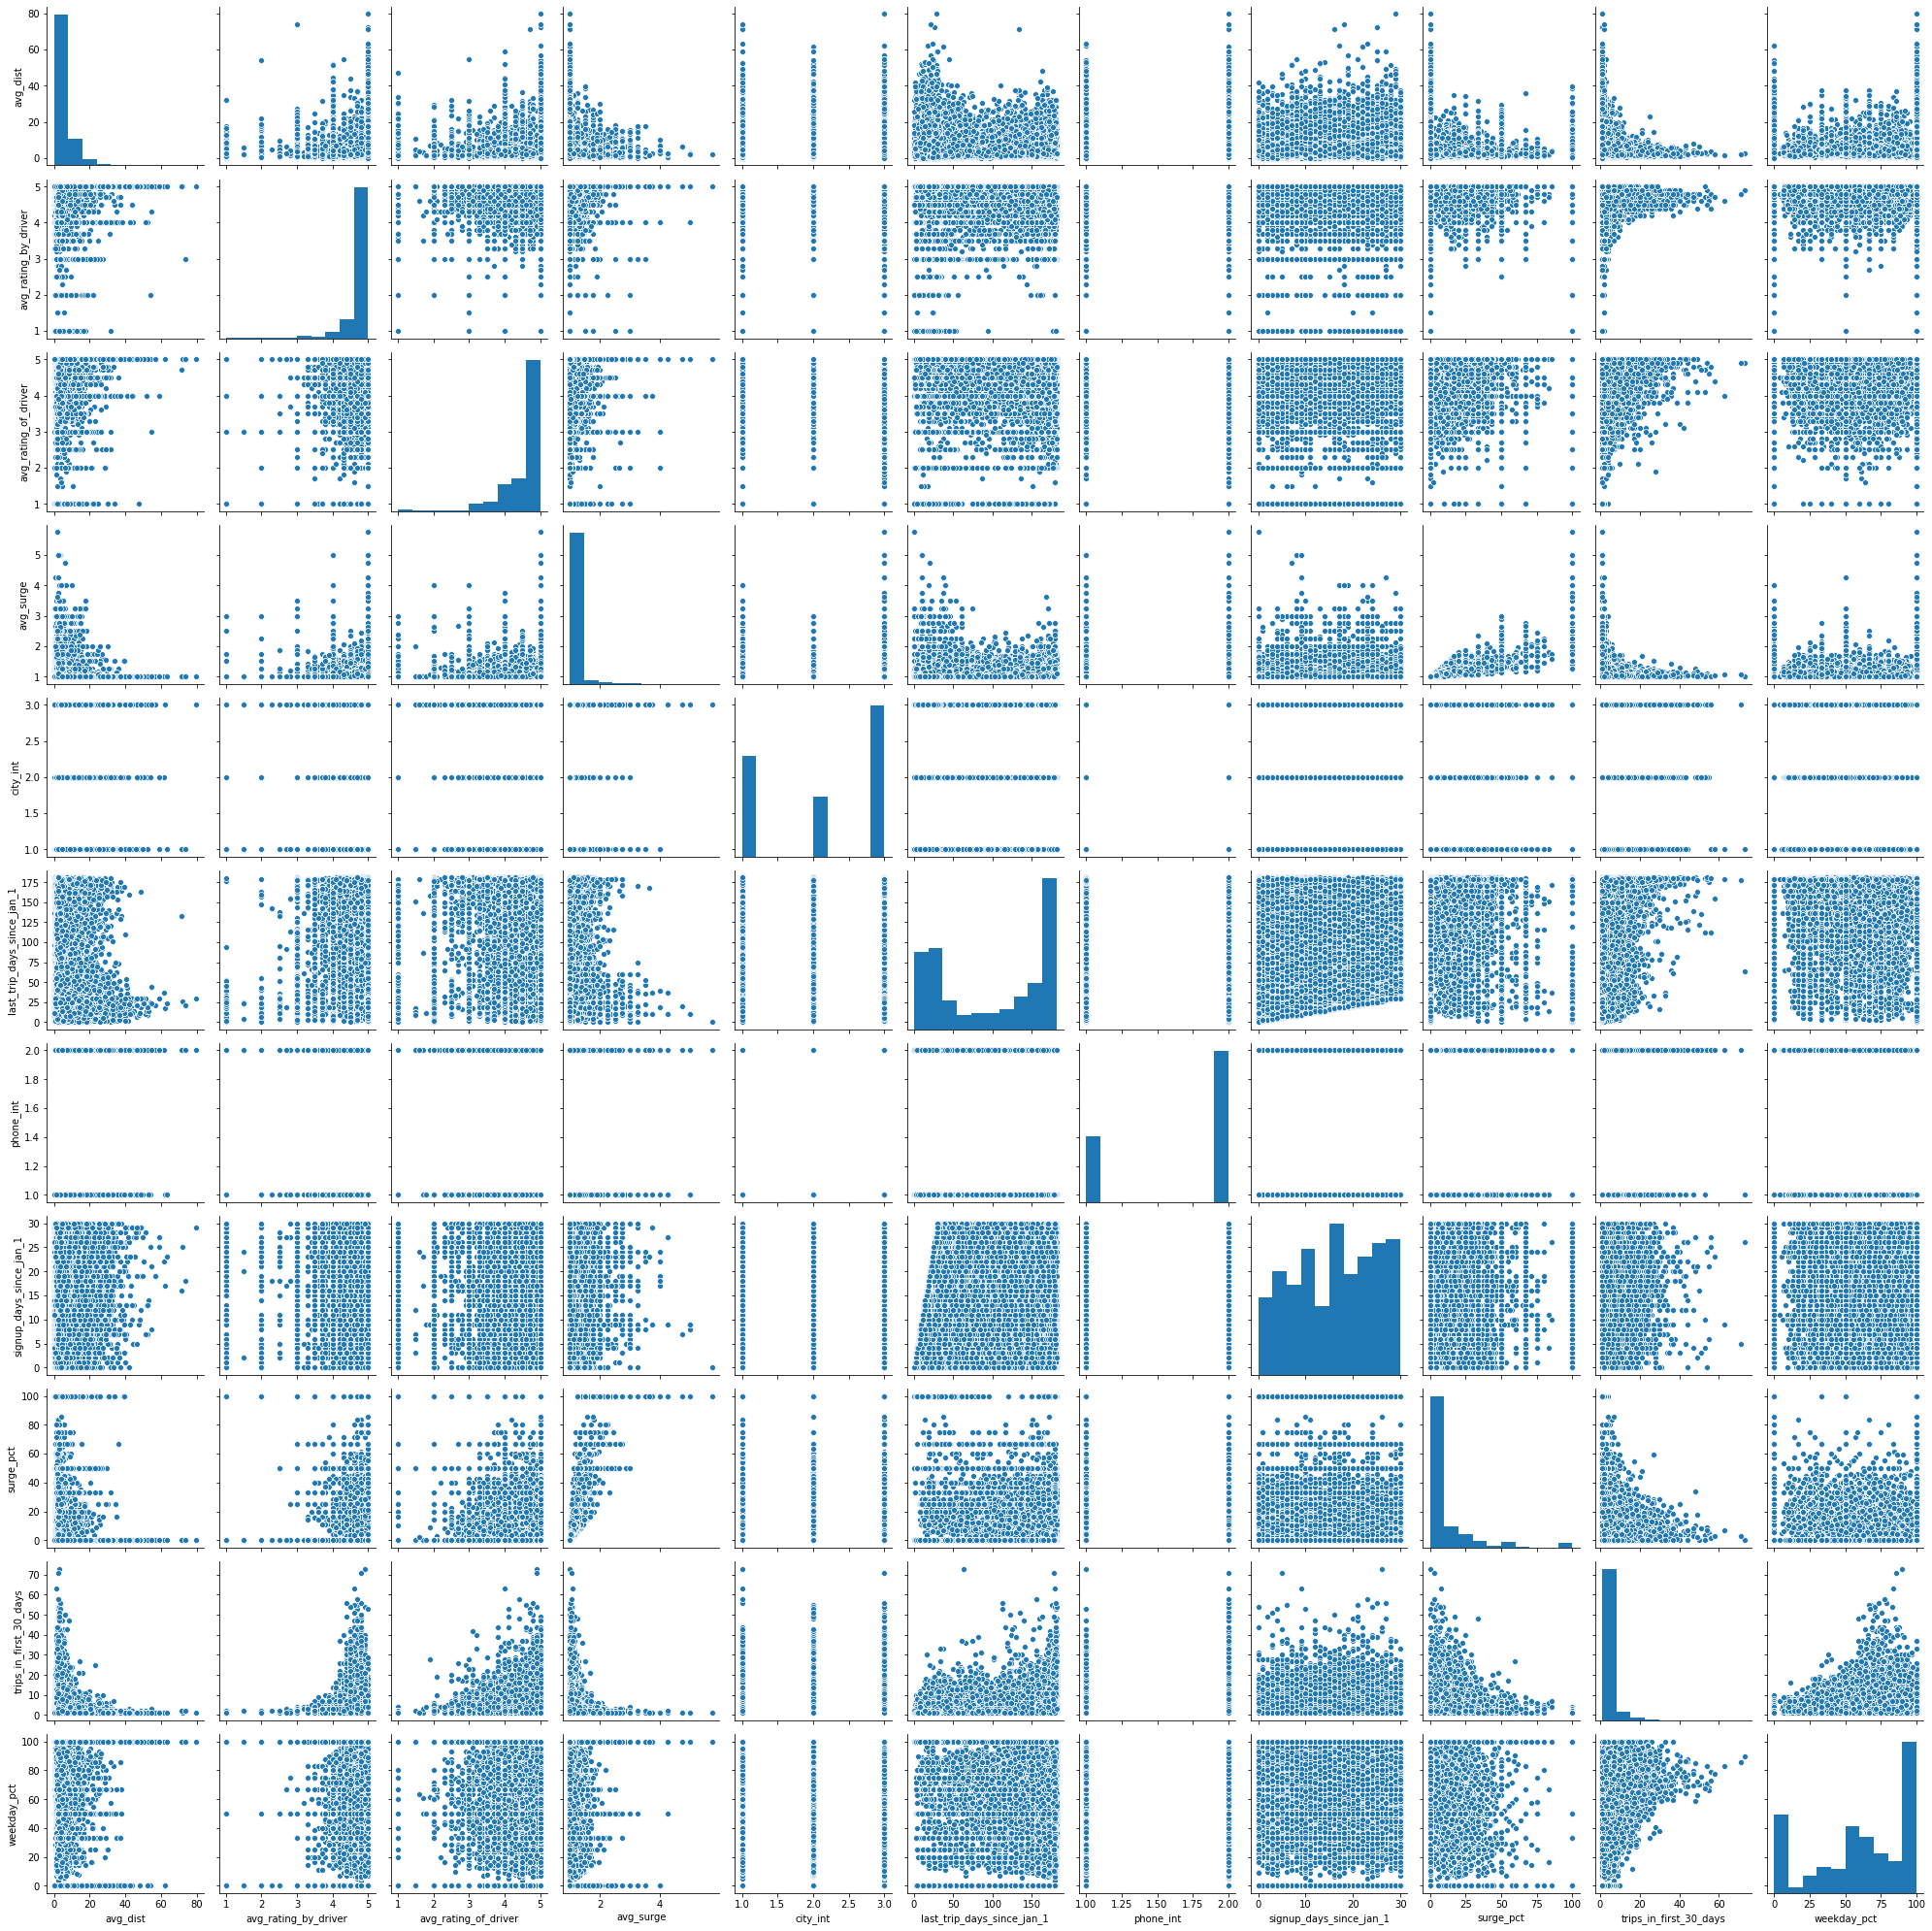

In [50]:
# Pairplot numerical features (drop bool)
sns.pairplot(clean_imp.drop(columns=['ultimate_black_user', 'active']))
plt.show()

### train_test_split

In [51]:
y = clean_imp['active']
X = clean_imp.drop(columns=['active'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13, stratify=y)

### Fill missing values using IterativeImputer

In [52]:
# impute missing values
imp = IterativeImputer(random_state=0)
X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_test_filled = pd.DataFrame(imp.transform(X_test))


In [53]:
imp = IterativeImputer(random_state=0)
X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_test_filled = pd.DataFrame(imp.transform(X_test))

In [54]:
# name columns, check values
X_train_filled.columns = X.columns
X_train_filled.index = X_train.index
X_train_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000
mean,5.521901,4.773536,4.594193,1.077398,2.163067,99.992544,1.696426,15.742206,9.059339,3.306819,0.389917,60.875009
std,5.221654,0.416261,0.561214,0.214681,0.883289,67.514440,0.457653,8.663886,19.039704,4.155564,0.487741,34.978636
min,0.010000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.450000,4.700000,4.400477,1.000000,1.000000,25.000000,1.000000,9.000000,0.000000,1.000000,0.000000,37.500000
50%,3.810000,5.000000,4.800000,1.000000,2.000000,116.000000,2.000000,17.000000,0.000000,2.000000,0.000000,66.700000
75%,6.490000,5.000000,5.000000,1.070000,3.000000,170.000000,2.000000,23.000000,11.100000,4.000000,1.000000,100.000000
max,73.880000,5.000000,5.000000,5.750000,3.000000,181.000000,2.000000,30.000000,100.000000,73.000000,1.000000,100.000000


In [55]:
# check values of previously categorical features
X_train_filled.city_int.value_counts().head()


3.0    12552
1.0     8331
2.0     5002
Name: city_int, dtype: int64

In [56]:
X_train_filled.phone_int.value_counts().head()

2.000000    17861
1.000000     7779
1.610015        1
1.621209        1
1.612668        1
Name: phone_int, dtype: int64

In [57]:
X_train_filled = X_train_filled.round({'phone_int': 0})
X_train_filled.phone_int.value_counts().head()

2.0    18106
1.0     7779
Name: phone_int, dtype: int64

In [58]:
# name columns, check values
X_test_filled.columns = X.columns
X_test_filled.index = X_test.index
X_test_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000
mean,5.613182,4.774419,4.584518,1.072517,2.157145,100.065013,1.697090,15.836829,8.870854,3.255418,0.390544,60.468838
std,5.449322,0.408443,0.569139,0.200898,0.889783,67.140059,0.457612,8.708528,18.777930,4.049804,0.487900,35.010974
min,0.010000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.490000,4.700000,4.400000,1.000000,1.000000,26.000000,1.000000,9.000000,0.000000,1.000000,0.000000,36.800000
50%,3.800000,5.000000,4.737498,1.000000,2.000000,116.000000,2.000000,17.000000,0.000000,2.000000,0.000000,66.700000
75%,6.640000,5.000000,5.000000,1.060000,3.000000,169.000000,2.000000,24.000000,10.500000,4.000000,1.000000,100.000000
max,79.690000,5.045520,5.000000,5.000000,3.000000,181.000000,2.000000,30.000000,100.000000,55.000000,1.000000,100.000000


In [59]:
X_test_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8629 entries, 20884 to 39063
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   avg_dist                    8629 non-null   float64
 1   avg_rating_by_driver        8629 non-null   float64
 2   avg_rating_of_driver        8629 non-null   float64
 3   avg_surge                   8629 non-null   float64
 4   city_int                    8629 non-null   float64
 5   last_trip_days_since_jan_1  8629 non-null   float64
 6   phone_int                   8629 non-null   float64
 7   signup_days_since_jan_1     8629 non-null   float64
 8   surge_pct                   8629 non-null   float64
 9   trips_in_first_30_days      8629 non-null   float64
 10  ultimate_black_user         8629 non-null   float64
 11  weekday_pct                 8629 non-null   float64
dtypes: float64(12)
memory usage: 876.4 KB


In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train_filled))
scaled_X_test = pd.DataFrame(scaler.transform(X_test_filled))


scaled_X_train.columns = X_test_filled.columns
scaled_X_train.index = X_train.index
scaled_X_test.columns = X_test_filled.columns
scaled_X_test.index = X_test.index
# scaled_X_test.columns

### Correlation Matrix

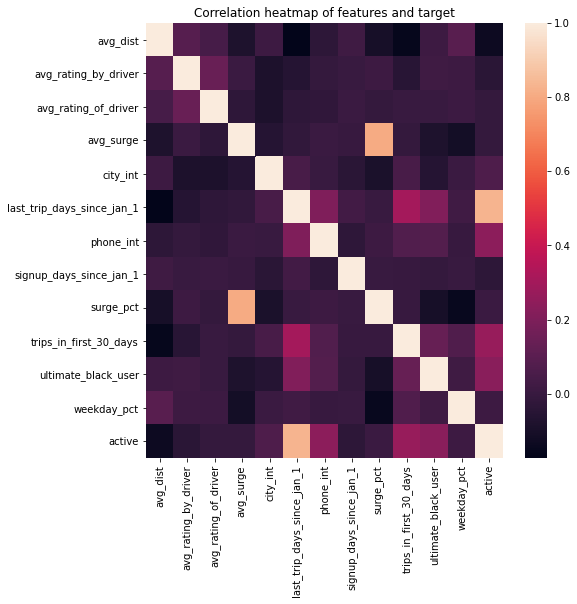

In [61]:
# calculate the correlation matrix of the processed data. 
corr_df = pd.concat([scaled_X_train, y_train], axis=1)
corr = corr_df.corr()

# plot the heatmap
fig = plt.figure(figsize=(8, 8)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('Correlation heatmap of features and target')
plt.show()

In [62]:
X_train_processed = scaled_X_train.drop(columns=['last_trip_days_since_jan_1', 'avg_surge']).to_numpy()
X_test_processed = scaled_X_test.drop(columns=['last_trip_days_since_jan_1', 'avg_surge']).to_numpy()

In [63]:
X_train_processed.shape, y_train.shape

((25885, 10), (25885,))

In [64]:
X_test_processed.shape, y_test.shape

((8629, 10), (8629,))

### Logistic Regression

In [65]:
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced').fit(X_train_processed, y_train)
print('Test accuracy with default hyperparameters: {}'.format(accuracy_score(clf.predict(X_test_processed), y_test)))

Test accuracy with default hyperparameters: 0.674353922818403


In [66]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced')

# define parameter values
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.001]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_processed, y_train)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")
model = grid_search.best_estimator_
y_pred = model.predict(X_test_processed)
print('Best score on test data: {}'.format(accuracy_score(y_pred, y_test)))


Best score on training data: 0.6943017191423605 using {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Best score on test data: 0.6811913315563797


In [67]:
from sklearn.metrics import classification_report
target_names = ['Not Active', 'Active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Active       0.75      0.72      0.74      5324
      Active       0.58      0.61      0.60      3305

    accuracy                           0.68      8629
   macro avg       0.66      0.67      0.67      8629
weighted avg       0.68      0.68      0.68      8629



In [68]:
from sklearn.ensemble import GradientBoostingClassifier
grd = GradientBoostingClassifier(random_state=42)
grd.fit(X_train_processed, y_train)
print('Test accuracy with default hyperparameters: {}'.format(accuracy_score(grd.predict(X_test_processed), y_test)))

Test accuracy with default hyperparameters: 0.8011357051802063
